In [1]:
import pandas as pd
import Testing
import numpy as  np
from scipy import stats

### Data preparation methods

In [2]:
def update_real_companion(row):
    if 'ir' not in row['composition']:
        r = np.array(row['real']).shape
        row['real'] = np.zeros(r)
    return row

def convert_to_numpy(row):
    """
    Convert nbeats, var, forecast, real, and error to numpy arrays
    :param row:
    :return:
    """
    row['nbeats'] = np.array(row['nbeats'])
    row['var'] = np.array(row['var'])
    row['forecast'] = np.array(row['forecast'])
    row['real'] = np.array(row['real'])
    row['error'] = np.array(row['error'])
    # if row has input column, convert it to numpy array
    if 'input' in row:
        row['input'] = np.array(row['input'])
    return row

#### Compute companion metrics

In [3]:
def update_companion_matrices(row):
    """
    Compute companion matrices for nbeats, var, and real
    :param row:
    :return:
    """
    nbeats, real = Testing.resize_companion_matrices(row['nbeats'], row['real'])
    row['nbeats'] = nbeats
    row['real'] = real
    var, real = Testing.resize_companion_matrices(row['var'], row['real'])
    row['var'] = var
    return row

def compute_companion_metrics(row):
    # Replace nan with 0 for nbeats, var and real
    #row['nbeats'] = np.nan_to_num(row['nbeats'])
    #row['var'] = np.nan_to_num(row['var'])
    #row['real'] = np.nan_to_num(row['real'])

    row['comp_frob_nbeats'] = Testing.compare_frobenius(row['nbeats'], row['real'])
    row['comp_frob_var'] = Testing.compare_frobenius(row['var'], row['real'])

    row['comp_cosine_nbeats'] = Testing.compare_cosine(row['nbeats'], row['real'])
    row['comp_cosine_var'] = Testing.compare_cosine(row['var'], row['real'])

    #row['comp_eigenvalues_nbeats'] = Testing.compare_eigenvalues(row['nbeats'], row['real'])
    #row['comp_eigenvalues_var'] = Testing.compare_eigenvalues(row['var'], row['real'])
    return row

#### Compute forecast metrics

In [4]:
def compute_forecast_metrics(row):
    """
    Compute forecast metrics
    :param row:
    :return:
    """
    if row['forecast'][0][0][0] is None:
        row['for_mse'] = None
        row['for_mape'] = None
        del row['forecast']
        return row
    forecast = row['forecast'].flatten()
    error = row['error']
    real = forecast + error
    row['for_mse'] = np.square(error).mean()
    row['for_log_mse'] = np.log(row['for_mse'])
    row['for_mape'] = np.abs(error / real).mean()
    del row['forecast']
    return row

#### All together

In [5]:
def read_and_prepare_results(name, column_of_interest):
    results = pd.read_json('results/'+name+'.json')
    print(pd.DataFrame(results[column_of_interest].value_counts()).T)
    results = results.apply(update_real_companion, axis=1)
    results = results.apply(convert_to_numpy, axis=1)

    results = results.apply(update_companion_matrices, axis=1)
    results = results.apply(compute_companion_metrics, axis=1)
    results = results.dropna()

    results = results.apply(compute_forecast_metrics, axis=1)
    # Count how many of each unique value there are in the column of interest
    print(pd.DataFrame(results[column_of_interest].value_counts()).T)
    return results

# Make plots

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def boxplot_together(dataframe, column1, column2, x=None):

    if x is None:
        x = ['composition', 'DGP']
    plt.figure(figsize=(12, 6))

    # Create the first subplot for column1
    plt.subplot(1, 2, 1)
    sns.boxplot(x=x[0], y=column1['col'], data=dataframe, showfliers=False)
    plt.xlabel('Data Generating Process')
    plt.ylabel(column1)
    plt.title('Boxplot of '+column1['name']+' by '+x[1])

    # Create the second subplot for column2
    plt.subplot(1, 2, 2)
    sns.boxplot(x=x[0], y=column2['col'], data=dataframe, showfliers=False)
    plt.xlabel('Data Generating Process')
    plt.ylabel(column2)
    plt.title(f'Boxplot of '+column2['name']+' by '+x[1])

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# Statistical tests

### companion_all
Is it as effective as VAR?

nbeats vs real: statistically different?
var vs real: statistically different?
nbeats vs var: statistically different?

In [7]:
data = read_and_prepare_results('companion_all', 'composition')
res = []
for composition in data['composition'].unique():
    d = data[data['composition'] == composition]
    t_forb, p_forb = stats.ttest_ind(d['comp_frob_nbeats'], d['comp_frob_var'])
    t_cos, p_cos = stats.ttest_ind(d['comp_frob_nbeats'], d['comp_frob_var'])
    res.append({'composition':composition,
                'frob_nbeats':d['comp_frob_nbeats'].mean(), 'frob_var':d['comp_frob_var'].mean(), 'significant-frob': p_forb < 0.05,
                'cos_nbeats':d['comp_cosine_nbeats'].mean(), 'cos_var':d['comp_cosine_var'].mean(), 'significant-cos': p_cos < 0.05,
                't-frob':t_forb, 'p-frob':p_forb, 't-cos':t_cos, 'p-cos':p_cos})

res = pd.DataFrame(res)
res

             ir  t_ir  s_ir  t_s_ir  t_s  rw_ir  t_rw_ir  s_rw_ir  t_s_rw_ir  \
composition  20    20    20      20   20     20       20       20         20   

             rw  
composition  20  
             ir  t_ir  s_ir  t_s_ir  t_s  rw_ir  t_rw_ir  s_rw_ir  t_s_rw_ir  \
composition  20    20    20      20   20     20       20       20         20   

             rw  
composition  20  


,composition,frob_nbeats,frob_var,significant-frob,cos_nbeats,cos_var,significant-cos,t-frob,p-frob,t-cos,p-cos
0,ir,0.234646,0.208265,False,0.997448,0.998027,False,1.577511,1.229676e-01,1.577511,1.229676e-01
1,t_ir,2.678182,0.896358,True,0.713426,0.962665,True,17.415975,1.045633e-19,17.415975,1.045633e-19
2,s_ir,1.493588,1.503423,False,0.904485,0.904025,False,-0.087292,9.308981e-01,-0.087292,9.308981e-01
3,t_s_ir,2.470488,1.783586,True,0.754416,0.872117,True,7.470742,5.725606e-09,7.470742,5.725606e-09
4,t_s,2.205618,2.577725,True,0.805701,0.759309,True,-4.066234,2.318908e-04,-4.066234,2.318908e-04
5,rw_ir,1.618508,1.606410,False,0.887632,0.890614,False,0.122653,9.030284e-01,0.122653,9.030284e-01
6,t_rw_ir,2.485815,1.608374,True,0.748740,0.890430,True,8.055722,9.628466e-10,8.055722,9.628466e-10
7,s_rw_ir,2.040204,2.097966,False,0.834342,0.829185,False,-0.514990,6.095428e-01,-0.514990,6.095428e-01
8,t_s_rw_ir,2.547825,2.103743,True,0.740591,0.828497,True,4.125440,1.942843e-04,4.125440,1.942843e-04
9,rw,1.678708,1.752905,True,0.872589,0.863403,True,-3.449732,1.388661e-03,-3.449732,1.388661e-03


# ANALYSIS
Significant difference in one = significant difference in the other. Significant different everytime a trend is included in the DGP. Additionally, the  random walk also has a significant difference between VAR and N-BEATS.

Check what types of differences we have in the companion matrix. Is it AR issues?

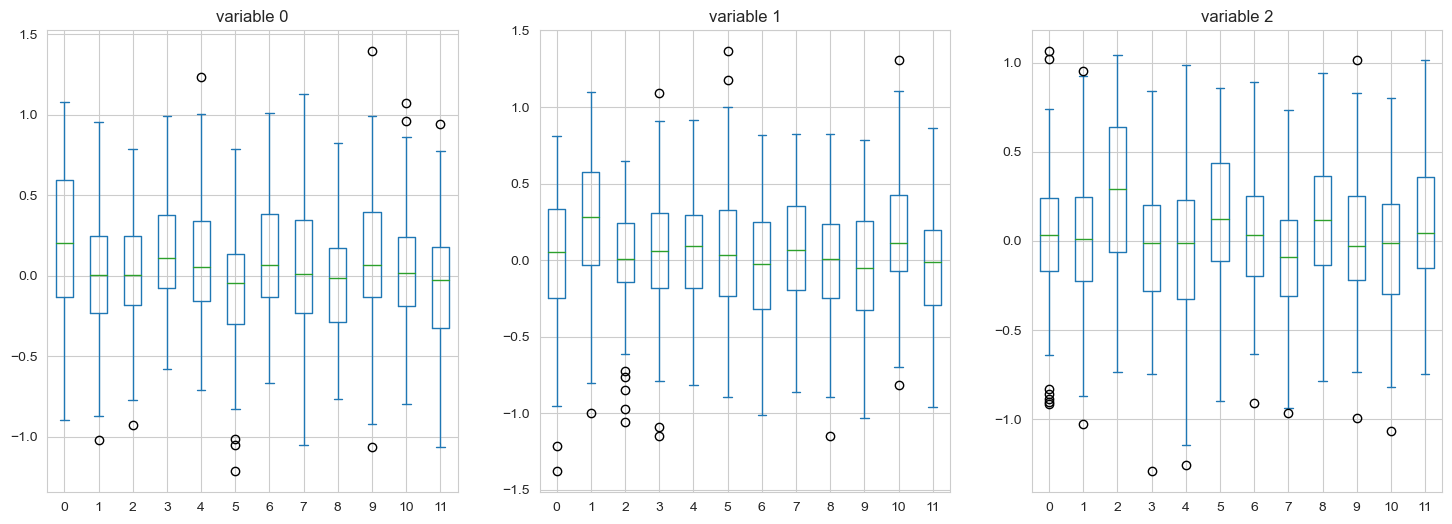

In [8]:
def comp_diff(row, variable_of_interest):
    diff = (row['nbeats'] - row['real'])[:3,:]
    res = []
    for var in range(diff.shape[0]):
        d = {variable_of_interest:row[variable_of_interest], 'variable':var}
        for idx in range(diff.shape[1]):
            d[idx] = diff[var][idx]
        res.append(pd.Series(d))
    return pd.DataFrame(res)

def boxplot_differences(df, loop_over):
    fig, axes = plt.subplots(1, len(df[loop_over].unique()), figsize=(18, 6))
    #plt.suptitle(f'Absolute difference between VAR block companion matrix and real companion matrix for trend simulations')
    i=0
    for var in df[loop_over].unique():
        df[df[loop_over]==var].drop(columns=[loop_over]).plot(kind='box', ax=axes[i])
        # Set title of the subplot
        axes[i].set_title(f'{loop_over} {var}')
        i+=1
    plt.show()

variable_of_interest = 'composition'

diff = pd.concat(data.apply(comp_diff, variable_of_interest=variable_of_interest, axis=1).tolist())
# Only keep rows where composition value in res[res['significant-frob'] | res['significant-cos']].composition
diff = diff[diff[variable_of_interest].isin(res[res['significant-frob'] | res['significant-cos']].composition)]
boxplot_differences(diff, 'variable')

Consistently overestimates the autoregressive value of each time series. Especially the first lag.

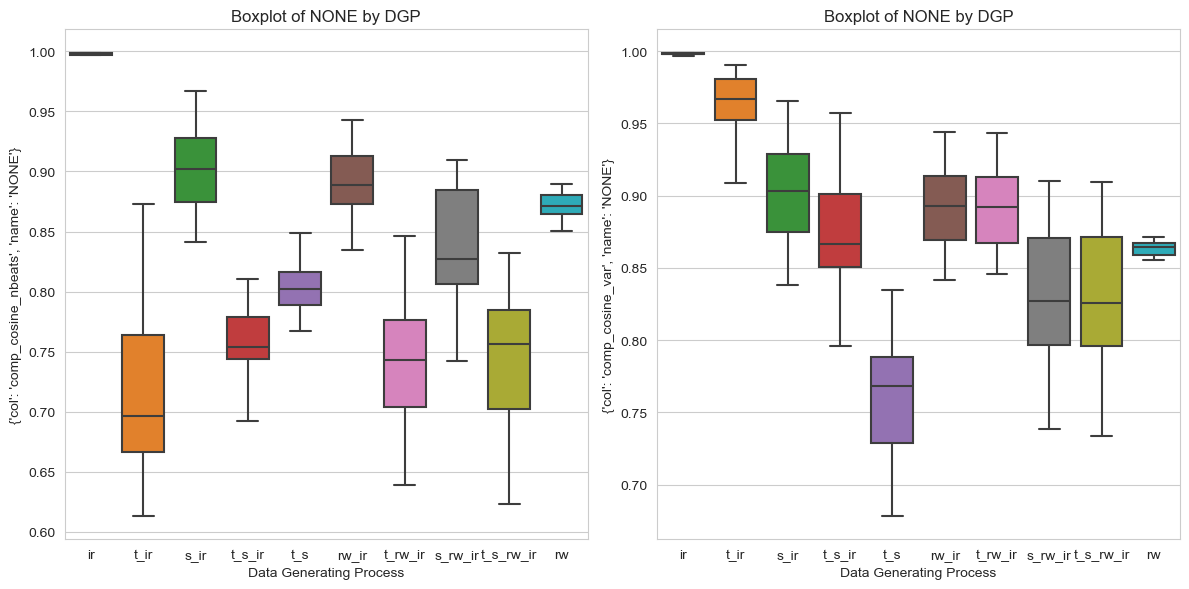

<Axes: xlabel='composition'>

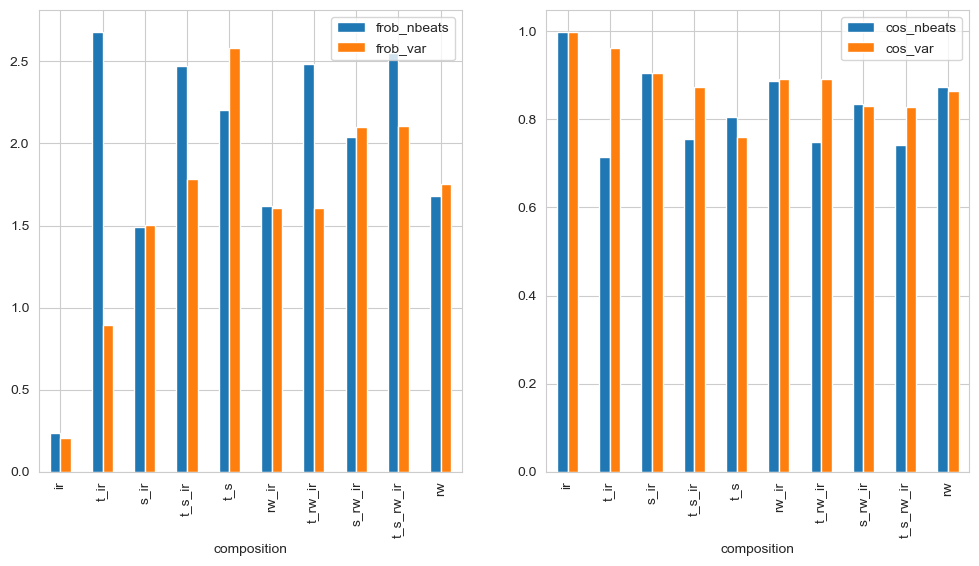

In [9]:
boxplot_together(data, {'col':'comp_cosine_nbeats', 'name':'NONE'}, {'col':'comp_cosine_var', 'name':'NONE'})
# Make figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Plot frob_nbeats and frob_var on the first subplot
res.set_index('composition')[['frob_nbeats', 'frob_var']].plot(kind='bar', ax=axes[0])
res.set_index('composition')[['cos_nbeats', 'cos_var']].plot(kind='bar', ax=axes[1])

### horizon_ir
Does making it forecast further deteriorates performance?

In [10]:
data = read_and_prepare_results('horizon_ir', 'horizon')
res = []
for composition in data['horizon'].unique():
    d = data[data['horizon'] == composition]
    t_forb, p_forb = stats.ttest_ind(d['comp_frob_nbeats'], d['comp_frob_var'])
    t_cos, p_cos = stats.ttest_ind(d['comp_frob_nbeats'], d['comp_frob_var'])
    res.append({'composition':composition,
                'frob_nbeats':d['comp_frob_nbeats'].mean(), 'frob_var':d['comp_frob_var'].mean(), 'significant-frob': p_forb < 0.05,
                'cos_nbeats':d['comp_cosine_nbeats'].mean(), 'cos_var':d['comp_cosine_var'].mean(), 'significant-cos': p_cos < 0.05,
                't-frob':t_forb, 'p-frob':p_forb, 't-cos':t_cos, 'p-cos':p_cos})

res = pd.DataFrame(res)
res

         1   5   10  20  50
horizon  20  20  20  20  20
         1   5   10  20  50
horizon  20  20  20  20  19


,composition,frob_nbeats,frob_var,significant-frob,cos_nbeats,cos_var,significant-cos,t-frob,p-frob,t-cos,p-cos
0,1,0.231872,0.208265,False,0.997514,0.998027,False,1.539548,1.319573e-01,1.539548,1.319573e-01
1,5,0.372234,0.208265,True,0.993357,0.998027,True,5.903475,7.722463e-07,5.903475,7.722463e-07
2,10,0.750952,0.208265,True,0.971615,0.998027,True,8.739148,1.257171e-10,8.739148,1.257171e-10
3,20,1.565241,0.208265,True,0.886981,0.998027,True,13.111550,1.115164e-15,13.111550,1.115164e-15
4,50,2.342602,0.207755,True,0.771859,0.998039,True,24.403318,5.486345e-24,24.403318,5.486345e-24


# ANALYSIS
The further the forecast, the worse the ability to infer the real companion matrix. This is true for only for N-BEATS. VAR is not affected by the horizon due to it being a statistical model that only does 1 ahead forecasts. I assume this is due to the fact that the custom block increases the magnitude of the coefficients so that the forecast doesn't fizzle out before the end of the horizon, to get a better overall MSE.

Check what types of differences we have in the companion matrix. Is it magnitude issues?

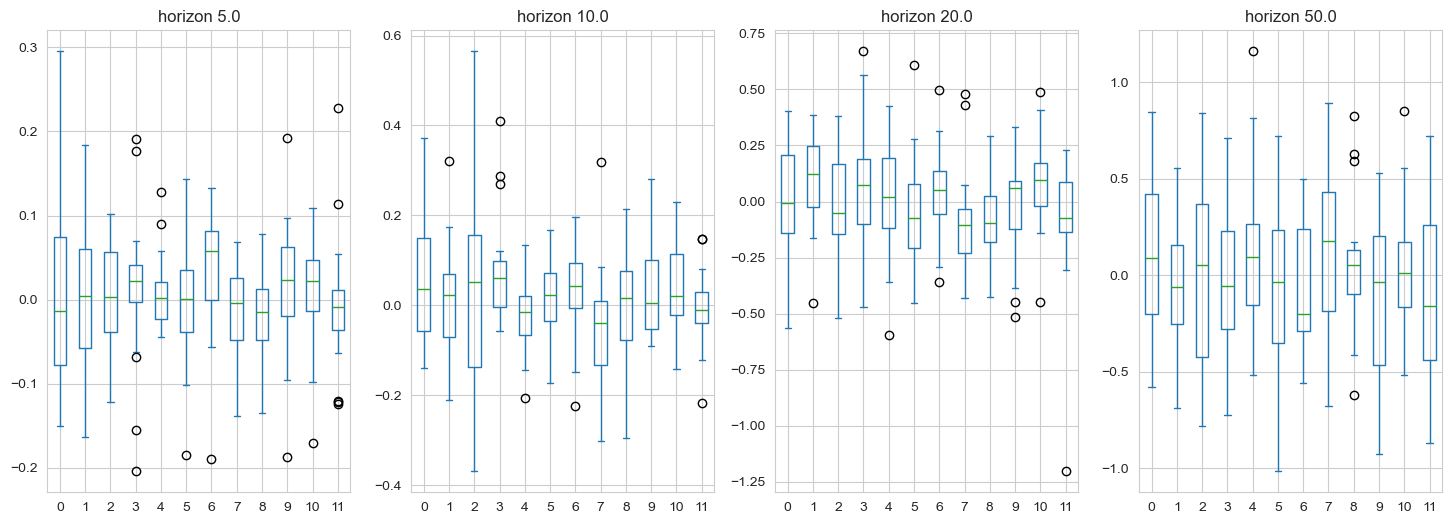

In [11]:
variable_of_interest = 'horizon'
diff = pd.concat(data.apply(comp_diff, variable_of_interest=variable_of_interest, axis=1).tolist())
# Only keep rows where composition value in res[res['significant-frob'] | res['significant-cos']].composition
diff = diff[diff[variable_of_interest].isin(res[res['significant-frob'] | res['significant-cos']].composition)]
boxplot_differences(diff[diff['variable']==0].drop(columns='variable'), loop_over='horizon')

Indeed, a magnitude issue. As we know through the cosine similarity, the direction of the  companion matrix from the custom block is in line with the direction of the real companion matrix. The only other thing that can change is the magnitude of the coefficients.

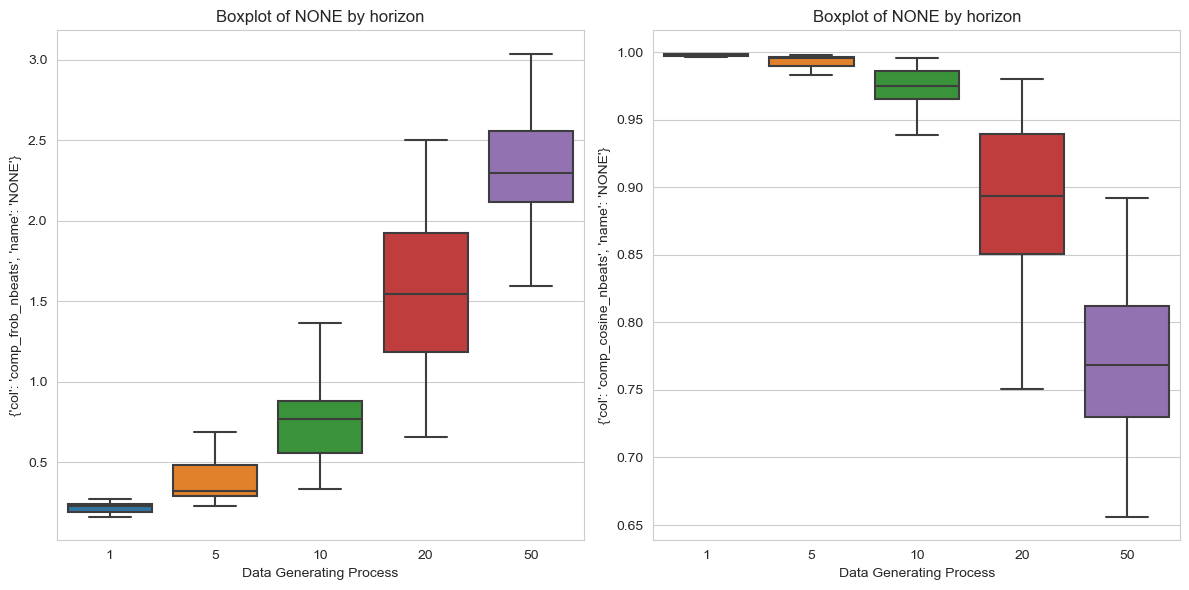

In [12]:
boxplot_together(data, {'col':'comp_frob_nbeats', 'name':'NONE'}, {'col':'comp_cosine_nbeats', 'name':'NONE'}, x=['horizon', 'horizon'])

### misspecified_ir
Does it work well when the lag order is wrong?

In [13]:
data = read_and_prepare_results('misspecified_ir', 'lags_included')
res = []
for composition in data['lags_included'].unique():
    d = data[data['lags_included'] == composition]
    t_forb, p_forb = stats.ttest_ind(d['comp_frob_nbeats'], d['comp_frob_var'])
    t_cos, p_cos = stats.ttest_ind(d['comp_frob_nbeats'], d['comp_frob_var'])
    res.append({'composition':composition,
                'frob_nbeats':d['comp_frob_nbeats'].mean(), 'frob_var':d['comp_frob_var'].mean(), 'significant-frob': p_forb < 0.05,
                'cos_nbeats':d['comp_cosine_nbeats'].mean(), 'cos_var':d['comp_cosine_var'].mean(), 'significant-cos': p_cos < 0.05,
                't-frob':t_forb, 'p-frob':p_forb, 't-cos':t_cos, 'p-cos':p_cos})

res = pd.DataFrame(res)
res

               2   4   8   16
lags_included  20  20  20  20
               2   4   8   16
lags_included  20  20  20  20


,composition,frob_nbeats,frob_var,significant-frob,cos_nbeats,cos_var,significant-cos,t-frob,p-frob,t-cos,p-cos
0,2,3.339553,3.341514,False,0.233435,0.234093,False,-0.032662,0.974115,-0.032662,0.974115
1,4,0.225814,0.208265,False,0.997674,0.998027,False,1.306678,0.199175,1.306678,0.199175
2,8,0.403156,0.352698,False,0.996347,0.997316,False,2.012893,0.051251,2.012893,0.051251
3,16,0.611482,0.558707,False,0.995928,0.996694,False,1.740378,0.089886,1.740378,0.089886


# ANALYSIS
There is no statistical difference between the companion matrices of N-BEATS and VAR in all scenarios.
Both the VAR and custom block perform bad when it comes to extracting the real companion matrix if only 2 lags were included. As more lags get introduced, both models get a higher frobenius distance. No Lasso regularization was used to bring coefficients down to 0, so lags that were irrelevant received very small coefficients (~0.03 on average). Whereas both model get very high cosine similarity, meaning that the companion matrices they inferred point in the same direction as the real companion matrix.

COMPUTE AVERAGE COEFFICIENT OF IRRELEVANT LAGS

[ 2.  4.  8. 16.]


<Axes: >

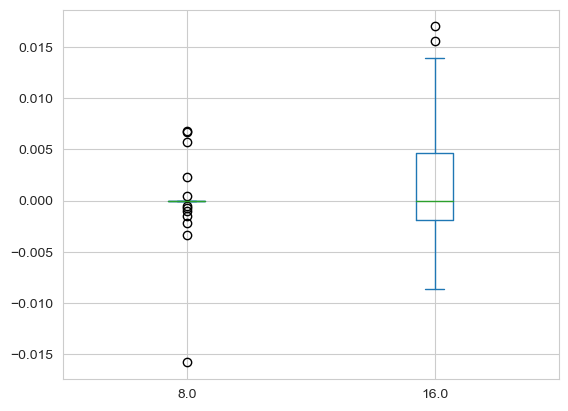

In [14]:
def comp_diff(row, variable_of_interest):
    diff = (row['nbeats'] - row['real'])[:3,:]
    res = []
    for var in range(diff.shape[0]):
        d = {variable_of_interest:row[variable_of_interest], 'variable':var}
        for idx in range(diff.shape[1]):
            d[idx] = diff[var][idx] if idx>11 else 0
        res.append(pd.Series(d))
    return pd.DataFrame(res)

variable_of_interest = 'lags_included'
diff = pd.concat(data.apply(comp_diff, variable_of_interest=variable_of_interest, axis=1).tolist())
print(diff['lags_included'].unique())
# Set NaN to 0
diff = diff.fillna(0)
diff = diff.groupby('lags_included').mean().drop(columns='variable')
diff.T.drop(columns=[2.0, 4.0]).plot(kind='box')

### all, seasonal, trend
How well does it fit in the N-beats family?
Does the trend block mess it up by predicting part of the AR process?

In [15]:
def compute_mse(row):
    return np.mean(row['error']**2)



In [16]:
all = read_and_prepare_results('all', 'composition')
trend = read_and_prepare_results('trend', 'composition')
seasonal = read_and_prepare_results('seasonal', 'composition')

res = []
for composition in trend['composition'].unique():
    a = all[all['composition'] == composition]
    s = seasonal[seasonal['composition'] == composition]
    t = trend[trend['composition'] == composition]

    r = {'composition':composition, 'frob_all':a['comp_frob_nbeats'].mean(), 'frob_trend':t['comp_frob_nbeats'].mean(), 'frob_seasonal':s['comp_frob_nbeats'].mean(),
         'cos_all':a['comp_cosine_nbeats'].mean(), 'cos_trend':t['comp_cosine_nbeats'].mean(), 'cos_seasonal':s['comp_cosine_nbeats'].mean()}

    r['mse_all'] = a.apply(compute_mse, axis=1).mean()
    r['mse_trend'] = t.apply(compute_mse, axis=1).mean()
    r['mse_seasonal'] = s.apply(compute_mse, axis=1).mean()

    a_t_t_forb, a_t_p_forb = stats.ttest_ind(a['comp_frob_nbeats'], t['comp_frob_nbeats'])
    a_t_t_cos, a_t_p_cos = stats.ttest_ind(a['comp_frob_nbeats'], t['comp_frob_nbeats'])

    a_s_t_forb, a_s_p_forb = stats.ttest_ind(a['comp_frob_nbeats'], s['comp_frob_nbeats'])
    a_s_t_cos, a_s_p_cos = stats.ttest_ind(a['comp_frob_nbeats'], s['comp_frob_nbeats'])

    t_s_t_forb, t_s_p_forb = stats.ttest_ind(t['comp_frob_nbeats'], s['comp_frob_nbeats'])
    t_s_t_cos, t_s_p_cos = stats.ttest_ind(t['comp_frob_nbeats'], s['comp_frob_nbeats'])

    r['a_t_significant-frob'] = a_t_p_forb < 0.05
    r['a_t_significant-cos'] = a_t_p_cos < 0.05
    r['a_s_significant-frob'] = a_s_p_forb < 0.05
    r['a_s_significant-cos'] = a_s_p_cos < 0.05
    r['t_s_significant-frob'] = t_s_p_forb < 0.05
    r['t_s_significant-cos'] = t_s_p_cos < 0.05

    r['a_t-p_frob'] = a_t_p_forb
    r['a_t-p-cos'] = a_t_p_cos
    r['a_t_t-frob'] = a_t_t_forb
    r['a_t_t-cos'] = a_t_t_cos

    r['a_s_t-p-frob'] = a_s_p_forb
    r['a_s_t-p-cos'] = a_s_p_cos
    r['a_s_t-frob'] = a_s_t_forb
    r['a_s_t-cos'] = a_s_t_cos

    r['t_s_t-p-frob'] = t_s_p_forb
    r['t_s_t-p-cos'] = t_s_p_cos
    r['t_s_t-frob'] = t_s_t_forb
    r['t_s_t-cos'] = t_s_t_cos

    res.append(r)

res = pd.DataFrame(res)
res.set_index('composition').T

             ir  t_ir  s_ir  t_s_ir  t_s  rw_ir  t_rw_ir  s_rw_ir  t_s_rw_ir  \
composition  20    20    20      20   20     20       20       20         20   

             rw  
composition  20  
             s_ir  ir  rw  rw_ir  s_rw_ir
composition    14  12   7      6        2
             ir  t_ir  s_ir  t_s_ir  t_s  rw_ir  t_rw_ir  s_rw_ir  t_s_rw_ir  \
composition  20    20    20      20   20     20       20       20         20   

             rw  
composition  20  
             ir  t_ir  s_ir  t_s_ir  t_s  rw_ir  t_rw_ir  s_rw_ir  t_s_rw_ir  \
composition  20    20    20      20   20     20       20       20         20   

             rw  
composition  20  
             ir  t_ir  s_ir  t_s_ir  t_s  rw_ir  t_rw_ir  s_rw_ir  t_s_rw_ir  \
composition  20    20    20      20   20     20       20       20         20   

             rw  
composition  20  
             ir  t_ir  s_ir  t_s_ir  t_s  rw_ir  t_rw_ir  s_rw_ir  t_s_rw_ir  \
composition  20    20    20      20   20     20 

composition,ir,t_ir,s_ir,t_s_ir,t_s,rw_ir,t_rw_ir,s_rw_ir,t_s_rw_ir,rw
frob_all,2.453258,NaN,2.408146,NaN,NaN,2.406008,NaN,2.360522,NaN,1.914389
frob_trend,2.604838,2.54151,2.502578,2.548506,2.065675,2.49692,2.474224,2.5254,2.423264,2.016585
frob_seasonal,2.484014,2.61296,2.500236,2.558411,1.971036,2.557166,2.56086,2.458127,2.560057,2.027713
cos_all,0.751026,NaN,0.760178,NaN,NaN,0.76085,NaN,0.763527,NaN,0.84287
cos_trend,0.725498,0.739556,0.742602,0.738387,0.823606,0.747732,0.750553,0.741982,0.758392,0.829892
cos_seasonal,0.748356,0.724079,0.74551,0.735177,0.835658,0.736525,0.733834,0.752961,0.733614,0.828471
mse_all,161652.952252,NaN,702784.441924,NaN,NaN,1661357038.664206,NaN,697599.726371,NaN,2101940359.758986
mse_trend,991.48071,6805.061805,10.285218,1413.772767,201721.490202,2578.168957,9298.902331,712.535357,7035.128426,3210942.492632
mse_seasonal,75.701066,1696994527.614642,60790096349354.265625,9880279502.748295,160889268.757913,33807363.658629,1902286.009871,5117.940446,38745588.364348,2478520.508915
a_t_significant-frob,False,False,False,False,False,False,False,False,False,False


No significant difference between the effectiveness of the custom block in all scenarios, and whether the trend/seasonality block is included or not.

Check whether the input of the custom block is stationary OR similar to the IR component

In [17]:
from statsmodels.tsa.stattools import adfuller
import DataGeneration
from Dataset import DataSet
import tensorflow as tf
import pandas as pd
import numpy as np
# Set tensorflow and numpy seed
tf.random.set_seed(42)
np.random.seed(42)
num_variables = 3
var_lag = 4
data = DataGeneration.generate_simulations(20, num_variables, 1000, var_lag)

def analyse_input(df):
    analysis = []
    for idx, row in df.iterrows():
        sim = row['sim']
        composition = row['composition']
        if 'ir' not in composition:
            continue
        print(idx, end=' ')
        # Prepare data
        dataset = DataSet(data[sim]['data'][composition].values)
        horizon = 1
        back_horizon = 100
        dataset.preprocessing(horizon, back_horizon, 0.8, 0.1)
        ir = DataSet(data[sim]['data']['ir'].values)
        ir.preprocessing(horizon, back_horizon, 0.8, 0.1)
        anal = []
        for i in range(len(row['input'])):
            real = ir.X_test[i].flatten()
            computed = row['input'][i].flatten()

            smape = np.mean(np.abs(real - computed) / (np.abs(real) + np.abs(computed)))
            # Run ADF test on computed. If < 0.05, then it is stationary
            adf_comp = adfuller(computed)
            adf_real = adfuller(real)
            anal.append({'smape':smape, 'adf_p-value':adf_comp[1], 'adf_real_p-value':adf_real[1]})
        anal = pd.DataFrame(anal).mean()
        anal['composition'] = composition
        analysis.append(anal)
    print()
    return pd.DataFrame(analysis)

analysis_all = analyse_input(all)
print(analysis_all.groupby('composition').mean())

0 2 5 10 12 20 22 35 42 52 60 62 65 82 102 112 120 122 130 140 142 145 150 155 157 160 162 167 170 175 180 182 190 192 
                smape   adf_p-value  adf_real_p-value
composition                                          
ir           0.912275  3.943753e-03          0.055106
rw_ir        0.996604  2.563003e-08          0.070805
s_ir         0.947829  2.504499e-02          0.098840
s_rw_ir      0.990918  4.370100e-03          0.007118


In [18]:
analysis_trend = analyse_input(trend)
print(analysis_trend.groupby('composition').mean())

0 1 2 3 5 6 7 8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 27 28 30 31 32 33 35 36 37 38 40 41 42 43 45 46 47 48 50 51 52 53 55 56 57 58 60 61 62 63 65 66 67 68 70 71 72 73 75 76 77 78 80 81 82 83 85 86 87 88 90 91 92 93 95 96 97 98 100 101 102 103 105 106 107 108 110 111 112 113 115 116 117 118 120 121 122 123 125 126 127 128 130 131 132 133 135 136 137 138 140 141 142 143 145 146 147 148 150 151 152 153 155 156 157 158 160 161 162 163 165 166 167 168 170 171 172 173 175 176 177 178 180 181 182 183 185 186 187 188 190 191 192 193 195 196 197 198 
                smape  adf_p-value  adf_real_p-value
composition                                         
ir           0.565275     0.419408          0.081813
rw_ir        0.826249     0.732579          0.081813
s_ir         0.640856     0.483271          0.081813
s_rw_ir      0.820072     0.700873          0.081813
t_ir         0.979763     0.798619          0.081813
t_rw_ir      0.969969     0.951907          0.081813
t_s_ir       0.980115  

In [19]:
analysis_seasonal = analyse_input(seasonal)
print(analysis_seasonal.groupby('composition').mean())

0 1 2 3 5 6 7 8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 27 28 30 31 32 33 35 36 37 38 40 41 42 43 45 46 47 48 50 51 52 53 55 56 57 58 60 61 62 63 65 66 67 68 70 71 72 73 75 76 77 78 80 81 82 83 85 86 87 88 90 91 92 93 95 96 97 98 100 101 102 103 105 106 107 108 110 111 112 113 115 116 117 118 120 121 122 123 125 126 127 128 130 131 132 133 135 136 137 138 140 141 142 143 145 146 147 148 150 151 152 153 155 156 157 158 160 161 162 163 165 166 167 168 170 171 172 173 175 176 177 178 180 181 182 183 185 186 187 188 190 191 192 193 195 196 197 198 
                smape  adf_p-value  adf_real_p-value
composition                                         
ir           0.806241     0.000002          0.081813
rw_ir        0.940646     0.000029          0.081813
s_ir         0.852271     0.000865          0.081813
s_rw_ir      0.944075     0.000006          0.081813
t_ir         0.994792     0.000070          0.081813
t_rw_ir      0.992021     0.000004          0.081813
t_s_ir       0.993863  

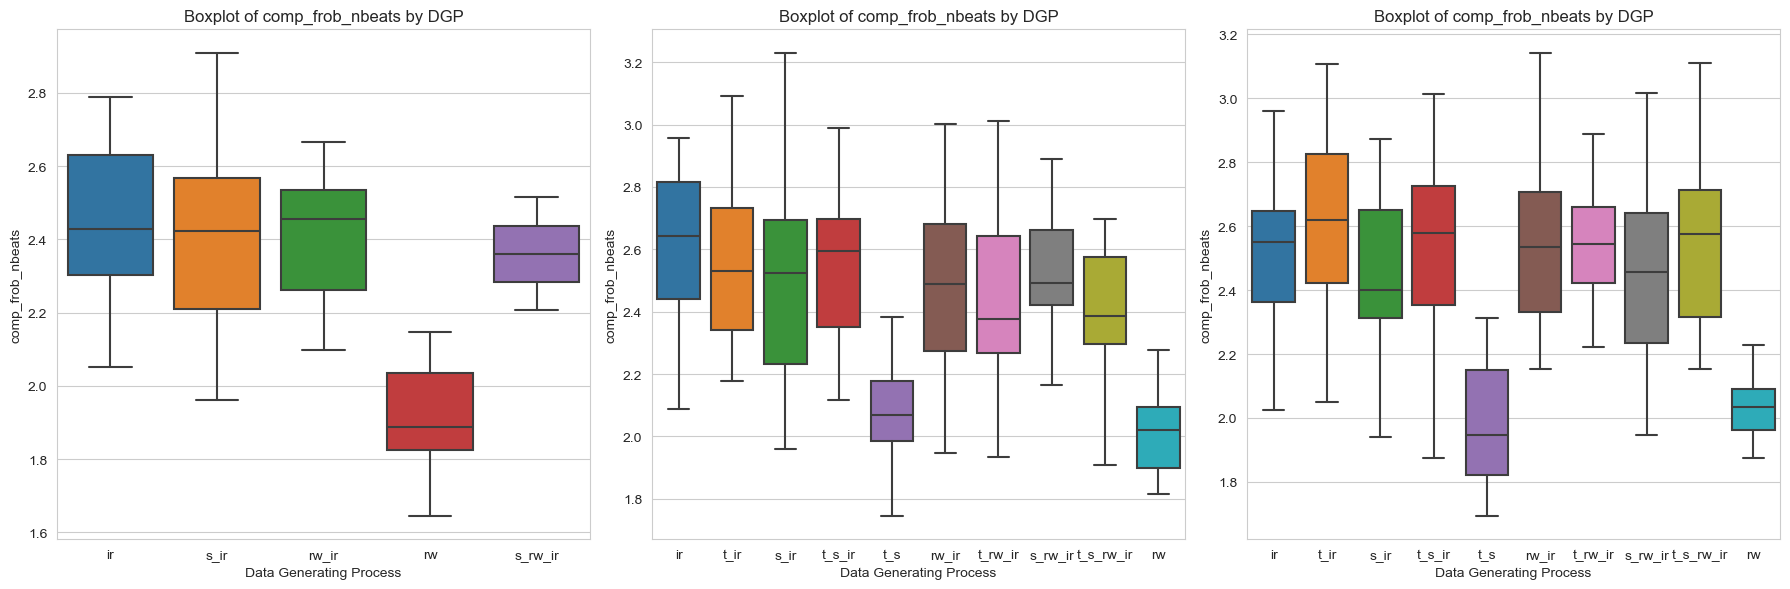

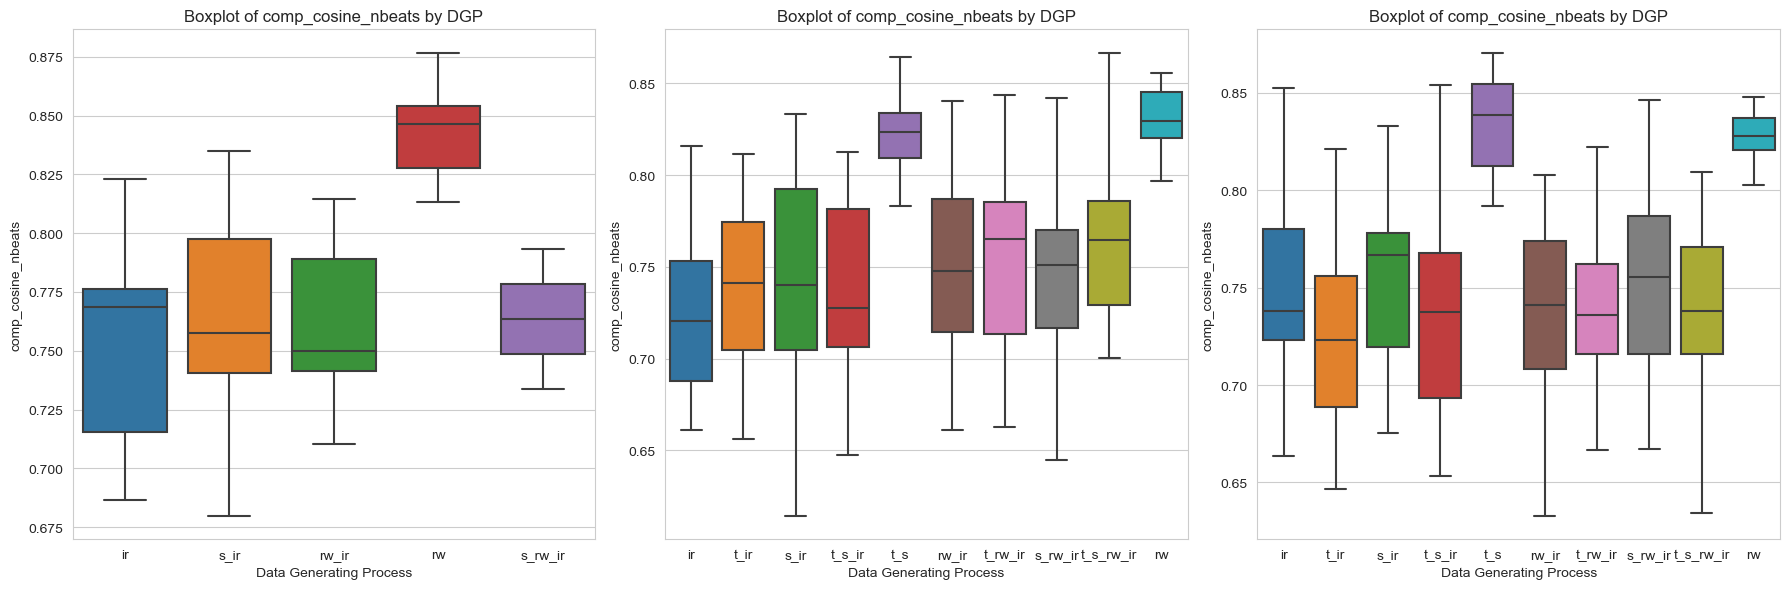

In [20]:
def boxplot_together(data, x=None):

    if x is None:
        x = ['composition', 'DGP']
    plt.figure(figsize=(6*len(data), 6))
    for i in range(len(data)):
        plt.subplot(1, len(data), i+1)
        sns.boxplot(x=x[0], y=data[i][1], data=data[i][0], showfliers=False)
        plt.xlabel('Data Generating Process')
        plt.ylabel(data[i][1])
        plt.title('Boxplot of '+data[i][1]+' by '+x[1])
    # Adjust the layout
    plt.tight_layout()
    # Show the plot
    plt.show()

boxplot_together([(all, 'comp_frob_nbeats'), (trend, 'comp_frob_nbeats'), (seasonal, 'comp_frob_nbeats')], x=['composition', 'DGP'])
boxplot_together([(all, 'comp_cosine_nbeats'), (trend, 'comp_cosine_nbeats'), (seasonal, 'comp_cosine_nbeats')], x=['composition', 'DGP'])

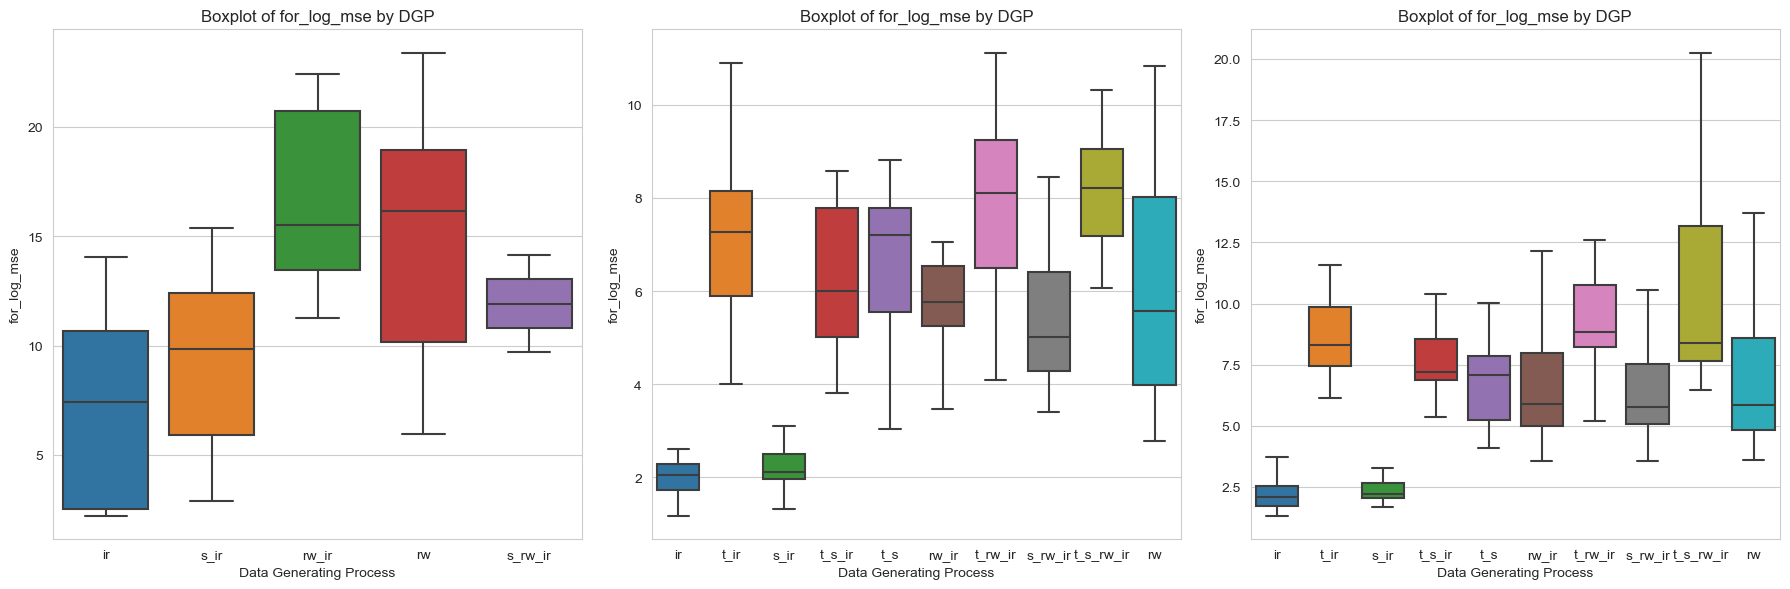

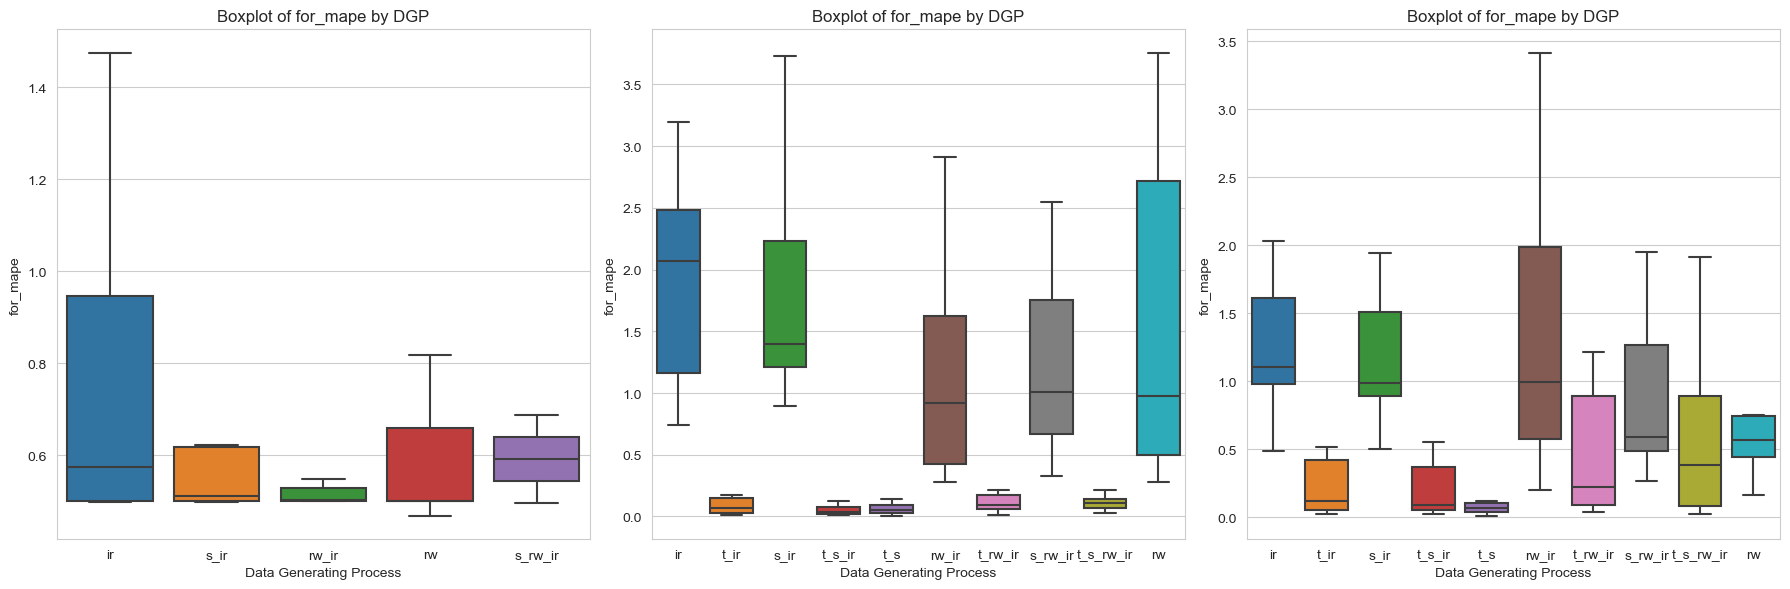

In [21]:
boxplot_together([(all, 'for_log_mse'), (trend, 'for_log_mse'), (seasonal, 'for_log_mse')], x=['composition', 'DGP'])
boxplot_together([(all, 'for_mape'), (trend, 'for_mape'), (seasonal, 'for_mape')], x=['composition', 'DGP'])